# Analisis de Algoritmos de Ordenamiento
Este notebook contiene:
1. Definicion de dependencias.
2. Analisis de complejidad (Big-O, Big-Theta, Big-Omega) e implementacion de algoritmos de ordenamiento.
3. Seccion de experimentos utilizando la **mediana** para benchmarking y graficas de rendimiento.

# 1. Dependencias

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import statistics
from typing import List, Sequence, TypeVar, Callable, Dict
import sys

# Configurar estilo de graficas
plt.style.use('seaborn-v0_8-whitegrid')


T = TypeVar("T")

## 2. Implementacion y Analisis de Algoritmos

### Bubble Sort
El **Bubble Sort** (ordenamiento burbuja) recorre repetidamente la lista, compara elementos adyacentes y los intercambia si estan en el orden incorrecto.

**Analisis de Complejidad:**
*   **Big-O (Peor Caso):** $O(n^2)$. Ocurre cuando la lista esta ordenada inversamente. Se realizan $n(n-1)/2$ comparaciones.
*   **Big-Theta (Caso Promedio):** $\Theta(n^2)$. En promedio, la mitad de los elementos estan desordenados.
*   **Big-Omega (Mejor Caso):** $\Omega(n)$. Ocurre cuando la lista ya esta ordenada (con la optimizacion de la bandera `swapped`).
*   **Espacio Auxiliar:** $O(1)$. Ordenamiento in-place (aunque esta implementacion devuelve una copia).

In [45]:
def bubble_sort(arr: Sequence[T]) -> List[T]:
    """
    Retorna una nueva lista ordenada usando bubble sort.
    """
    a: List[T] = list(arr)
    n = len(a)
    for i in range(n):
        swapped = False
        for j in range(0, n - 1 - i):
            if a[j] > a[j + 1]:
                a[j], a[j + 1] = a[j + 1], a[j]
                swapped = True
        if not swapped:
            break
    return a

### Insertion Sort
El **Insertion Sort** (ordenamiento por insercion) construye la lista ordenada un elemento a la vez, tomando un elemento y colocandolo en su posicion correcta comparandolo con los anteriores.

**Analisis de Complejidad:**
*   **Big-O (Peor Caso):** $O(n^2)$. Ocurre cuando la lista esta en orden inverso.
*   **Big-Theta (Caso Promedio):** $\Theta(n^2)$.
*   **Big-Omega (Mejor Caso):** $\Omega(n)$. Ocurre cuando la lista ya esta ordenada o casi ordenada.
*   **Espacio Auxiliar:** $O(1)$. Ordenamiento in-place.

In [46]:
def insertion_sort(arr: Sequence[T]) -> List[T]:
    """Retorna una nueva lista ordenada usando insertion sort."""
    a: List[T] = list(arr)
    for i in range(1, len(a)):
        key = a[i]
        j = i - 1
        while j >= 0 and a[j] > key:
            a[j + 1] = a[j]
            j -= 1
        a[j + 1] = key
    return a

### Merge Sort
El **Merge Sort** es un algoritmo de "divide y venceras". Divide la lista en mitades iguales recursivamente hasta tener listas de 1 elemento, y luego une (merge) las sublistas ordenadas.

**Analisis de Complejidad:**
*   **Big-O (Peor Caso):** $O(n \log n)$. La division siempre es logaritmica y la mezcla es lineal.
*   **Big-Theta (Caso Promedio):** $\Theta(n \log n)$.
*   **Big-Omega (Mejor Caso):** $\Omega(n \log n)$. No importa el orden inicial, siempre divide y mezcla.
*   **Espacio Auxiliar:** $O(n)$. Requiere espacio extra para las sublistas temporales durante la mezcla.

In [47]:
def merge_sort(arr: Sequence[T]) -> List[T]:
    """Retorna una nueva lista usando merge sort (estable)."""
    if len(arr) <= 1:
        return list(arr)

    def _merge(left: List[T], right: List[T]) -> List[T]:
        i = j = 0
        out: List[T] = []
        while i < len(left) and j < len(right):
            if left[i] <= right[j]:
                out.append(left[i])
                i += 1
            else:
                out.append(right[j])
                j += 1
        out.extend(left[i:])
        out.extend(right[j:])
        return out

    mid = len(arr) // 2
    left = merge_sort(arr[:mid])
    right = merge_sort(arr[mid:])
    return _merge(left, right)

### Quick Sort (In-Place / Optimized)
El **Quick Sort** tambien usa "divide y venceras". Elige un elemento como "pivote" y particiona la lista en elementos menores y mayores al pivote. Luego ordena recursivamente.  
*Nota: La implementacion provista a continuacion usa un estilo funcional (mas claro pero usa mas espacio).*

**Analisis de Complejidad:**
*   **Big-O (Peor Caso):** $O(n^2)$. Ocurre si el pivote es siempre el minimo/maximo (ej. lista ya ordenada y pivote es el primero).
*   **Big-Theta (Caso Promedio):** $\Theta(n \log n)$. Ocurre cuando el pivote divide la lista balanceadamente.
*   **Big-Omega (Mejor Caso):** $\Omega(n \log n)$.
*   **Espacio Auxiliar:** $O(\log n)$ (stack de recursion) hasta $O(n)$ en el peor caso.

In [48]:
def quick_sort(arr: Sequence[T]) -> List[T]:
    """Retorna una nueva lista ordenada con quick sort (estilo funcional)."""
    a: List[T] = list(arr)
    if len(a) <= 1:
        return a
    pivot = a[len(a) // 2]
    left = [x for x in a if x < pivot]
    middle = [x for x in a if x == pivot]
    right = [x for x in a if x > pivot]
    return quick_sort(left) + middle + quick_sort(right)

def python_sort(arr: Sequence[T]) -> List[T]:
    """Wrapper para el Timsort nativo de Python."""
    return sorted(arr)

## 3. Seccion de Pruebas y Experimentos
En esta seccion realizamos pruebas de rendimiento.  
Se utilizaran listas de enteros aleatorios de diferentes tamaños.  
Para cada tamaño y algoritmo, se realizaran multiples ejecuciones (trials) y se tomara la **mediana** del tiempo de ejecucion para reducir el ruido provocado por otros procesos del sistema.

In [49]:
# Funciones de utilidad para los experimentos

def run_benchmark(algorithm: Callable[[List[int]], List[int]], sizes: List[int], trials: int = 5) -> List[float]:
    """
    Ejecuta el algoritmo para diferentes tamaños de entrada y retorna la MEDIANA de los tiempos.
    """
    median_times = []
    
    for n in sizes:
        times = []
        for _ in range(trials):
            # Generar lista aleatoria
            arr = [random.randint(0, n * 10) for _ in range(n)]
            
            # Medir tiempo
            start_time = time.perf_counter()
            algorithm(arr)
            end_time = time.perf_counter()
            
            times.append(end_time - start_time)
        
        # Calcular mediana de los tiempos para este tamaño n
        median_time = statistics.median(times)
        median_times.append(median_time)
        
    return median_times

In [50]:
# Configuracion de los experimentos
# Tamaños de entrada (N)
sizes = [100, 500, 1000, 2000, 3000, 4000, 5000]

# Algoritmos a probar
algorithms = {
    "Bubble Sort": bubble_sort,
    "Insertion Sort": insertion_sort,
    "Merge Sort": merge_sort,
    "Quick Sort": quick_sort,
    "Python Sort (Timsort)": python_sort
}

# Almacenar resultados
results = {}

print(f"Iniciando benchmark con tamaños: {sizes}")
print("-" * 40)

for name, func in algorithms.items():
    print(f"Probando {name}...")
    # Para algoritmos O(n^2), limitamos el tamaño si es muy grande para no demorar demasiado
    if name in ["Bubble Sort", "Insertion Sort"]:
        current_sizes = [s for s in sizes if s <= 2000] # Limite para los lentos
    else:
        current_sizes = sizes
        
    median_times = run_benchmark(func, current_sizes, trials=7)
    results[name] = (current_sizes, median_times)
    print(f"  -> Terminado.")

print("-" * 40)
print("Benchmarking completo.")

Iniciando benchmark con tamaños: [100, 500, 1000, 2000, 3000, 4000, 5000]
----------------------------------------
Probando Bubble Sort...
  -> Terminado.
Probando Insertion Sort...
  -> Terminado.
Probando Merge Sort...
  -> Terminado.
Probando Quick Sort...
  -> Terminado.
Probando Python Sort (Timsort)...
  -> Terminado.
----------------------------------------
Benchmarking completo.


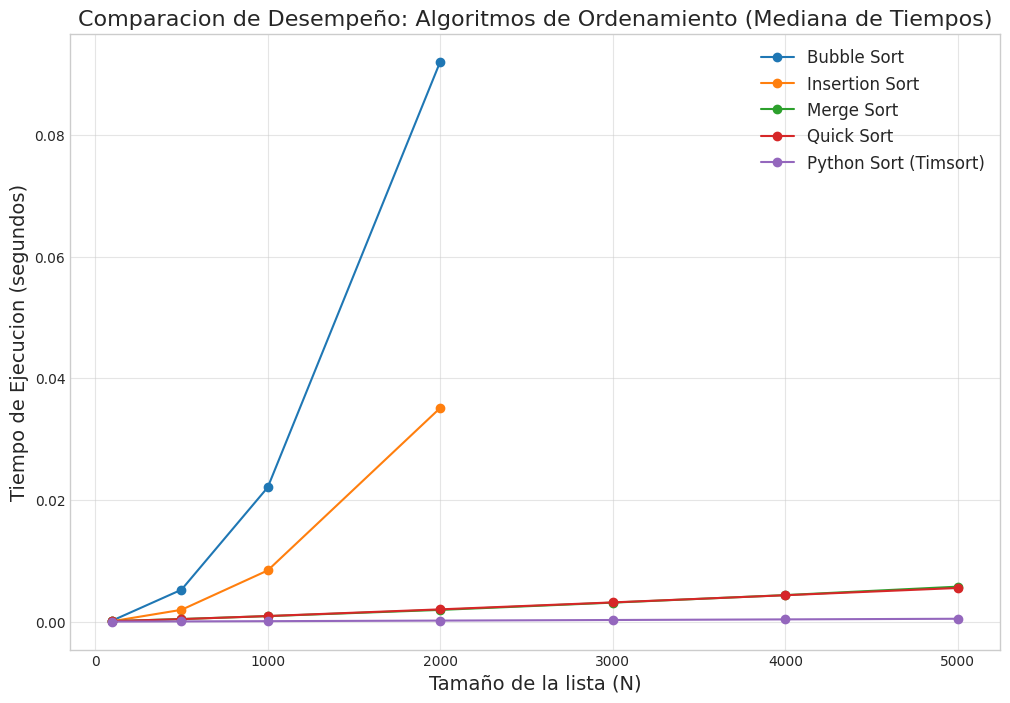

In [54]:
# Graficar Resultados

plt.figure(figsize=(12, 8))

for name, (sizes_run, times) in results.items():
    plt.plot(sizes_run, times, marker='o', label=name)

plt.title('Comparacion de Desempeño: Algoritmos de Ordenamiento (Mediana de Tiempos)', fontsize=16)
plt.xlabel('Tamaño de la lista (N)', fontsize=14)
plt.ylabel('Tiempo de Ejecucion (segundos)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.xscale('linear')
plt.yscale('linear') # Cambiar a 'log' si se quiere ver diferencia de ordenes de magnitud mas claro

plt.show()

### Analisis de Resultados
A partir de la grafica anterior podemos concluir:

1.  **Crecimiento Cuadratico ($O(n^2)$):** 
    - **Bubble Sort** e **Insertion Sort** muestran una curva parabolica. 
    - Observamos que el tiempo aumenta dramaticamente a medida que $N$ crece, lo que los hace ineficientes para listas de gran tamaño.
    - El **Bubble Sort** es notablemente mas lento que el **Insertion Sort** debido a la cantidad de intercambios constantes que realiza.

2.  **Crecimiento Loglineal ($O(n \log n)$):**
    - **Merge Sort** y **Quick Sort** presentan una curva casi lineal en comparacion con los algoritmos previos. 
    - Son mucho mas estables y eficientes para el procesamiento de datos masivos.
    
3.  **Optimizacion Nativa:**
    - **Python Sort (Timsort)** supera a todas nuestras implementaciones manuales. Esto se debe a que esta escrito en C y utiliza tecnicas avanzadas como el reconocimiento de "runs" (sub-listas ya ordenadas).

**Conclusion:** Para aplicaciones reales, siempre debemos preferir algoritmos con complejidad $O(n \log n)$ o utilizar las herramientas nativas del lenguaje.


## 4. Casos donde las Complejidades Coinciden ($O = \Theta = \Omega$)

Existen algoritmos cuyo comportamiento **no depende del orden inicial de los elementos**. En estos casos, el mejor, peor y promedio escenario tienen el mismo comportamiento asintotico.

#### Ejemplo 1: Merge Sort
Como vimos anteriormente, Merge Sort siempre divide el arreglo por la mitad y luego realiza una mezcla (merge) lineal. No importa si los datos estan ordenados, invertidos o aleatorios; el algoritmo hara exactamente la misma cantidad de divisiones y comparaciones proporcionales a $n \log n$.

**Complejidad:** $O(n \log n) = \Theta(n \log n) = \Omega(n \log n)$.

#### Ejemplo 2: Selection Sort
Selection Sort siempre busca el elemento minimo en el resto de la lista, sin importar si ya estaba en su lugar o no. Realiza dos bucles anidados fijos.

**Complejidad:** $O(n^2) = \Theta(n^2) = \Omega(n^2)$.


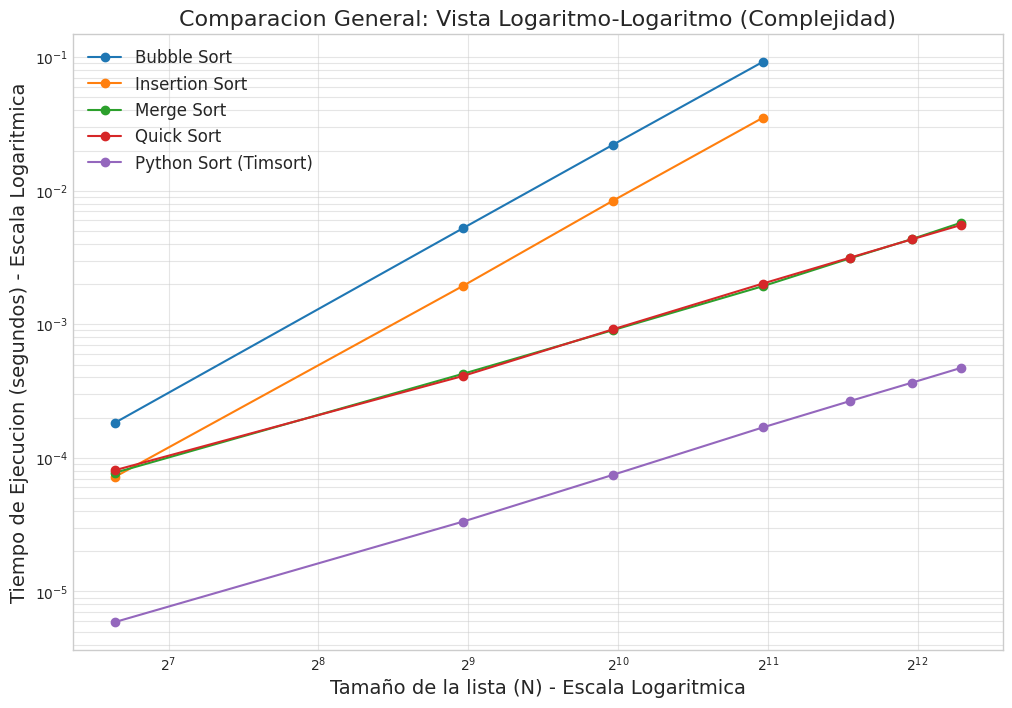

In [55]:
# Grafica General de Complejidad (Escala Log-Log)
# Al usar escalas logaritmicas, podemos apreciar la diferencia en los ordenes de magnitud
# de forma mas clara, ya que las distancias constantes representan factores constantes 
# y las pendientes representan el exponente de complejidad.

plt.figure(figsize=(12, 8))

for name, (sizes_run, times) in results.items():
    # Solo graficamos si hay datos disponibles
    if times:
        plt.plot(sizes_run, times, marker='o', label=name)

# Configuramos ambos ejes en escala logaritmica
plt.xscale('log', base=2)
plt.yscale('log')

plt.title('Comparacion General: Vista Logaritmo-Logaritmo (Complejidad)', fontsize=16)
plt.xlabel('Tamaño de la lista (N) - Escala Logaritmica', fontsize=14)
plt.ylabel('Tiempo de Ejecucion (segundos) - Escala Logaritmica', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()
